# Demo 08 - Predictive Models: Regression

In this notebook we look at the basics of how to do a linear regression using various Python modules. We don't do gradient descent directly because it's easier to just use modules!

In [24]:
# first, mount your google drive, change to the course folder, pull latest changes, and change to the lab folder.
# Startup Magic to: (1) Mount Google Drive
# (2) Change to Course Folder
# (3) Pull latest Changes
# (4) Move to the Demo Directory so that the data files are available

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/cmps3160
# !git pull
%cd _demos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cmps3160
/content/drive/My Drive/cmps3160/_demos


In [25]:
# Includes and Standard Magic...
### Standard Magic and startup initializers.

# Load Numpy
import numpy as np
# Load MatPlotLib
import matplotlib
import matplotlib.pyplot as plt
# Load Pandas
import pandas as pd
# Load Stats
from scipy import stats

# This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Show a ludicrus number of rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading and Understanding the Data

For this work we will be using data from: Generalized body composition prediction equation for men using simple measurement techniques", K.W. Penrose, A.G. Nelson, A.G. Fisher, FACSM, Human Performance research Center, Brigham Young University, Provo, Utah 84602 as listed in Medicine and Science in Sports and Exercise, vol. 17, no. 2, April 1985, p. 189.

[Data availabe here.](http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html)


In [45]:
# Load the Penrose Data and have a look.
df_penrose = pd.read_csv("./data/bodyfat.csv")
df_penrose.head()

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [31]:
# This is a bit much so let's only use a smaller part of the data for the moment.
observations = ['Age', 'Neck', 'Forearm', 'Wrist']
df_penrose[observations + ['bodyfat']].head()

,Age,Neck,Forearm,Wrist,bodyfat
0,23,36.2,27.4,17.1,12.3
1,22,38.5,28.9,18.2,6.1
2,22,34.0,25.2,16.6,25.3
3,26,37.4,29.4,18.2,10.4
4,24,34.4,27.7,17.7,28.7


In [46]:
# How many observations do we have?
len(df_penrose)

252

Let's do some really basic scatter plotting...

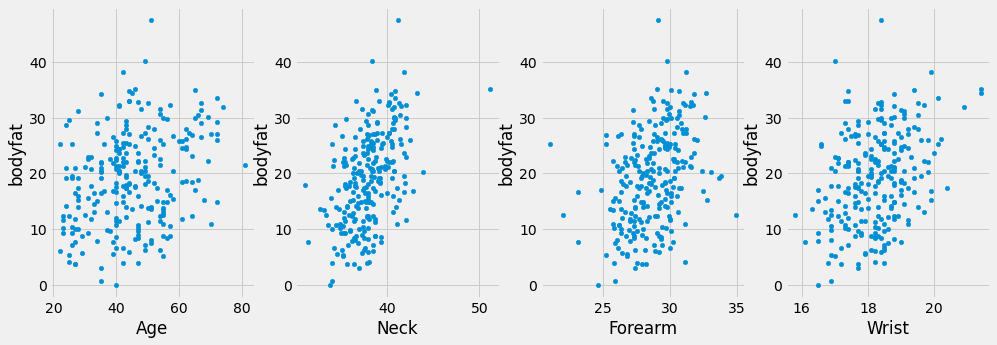

In [32]:
# First we iterate over the observations and see what we have.
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

## Many Ways to Find a Linear Regression

Let's say we want to look at some linear regressions of single variables to see what is going on!  So let's plot some regression lines.  Note that there are at least a few different ways -- [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), [sklearn.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial), [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), and [statsmodels](https://www.statsmodels.org/stable/index.html).

Here's a good article about it [Data science with Python: 8 ways to do linear regression and measure their speed](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/).

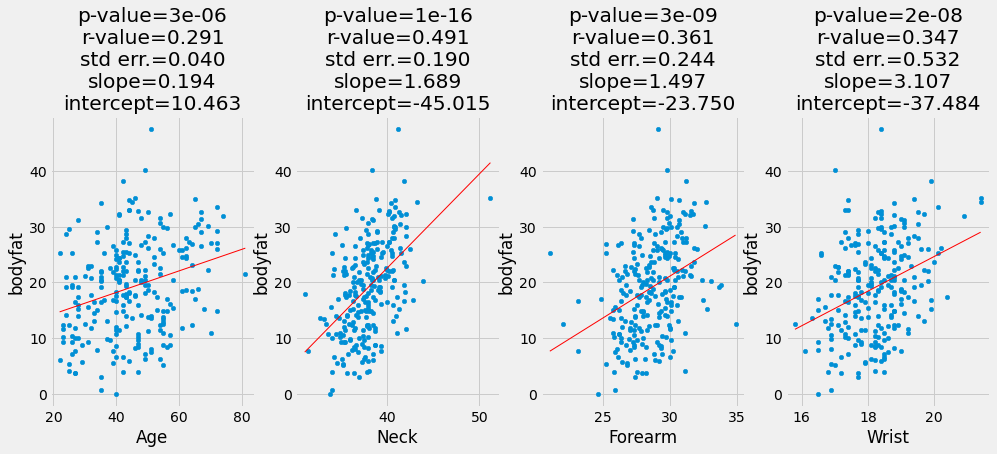

In [44]:
import math
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value is whether or not the slope is 0, not if the correlation is significant.
def regress_with_stats(df_penrose, observations):
  fig, ax = plt.subplots(1, 4, figsize=(15,5), sharex=False)

  for i,o in enumerate(observations):
      slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[o],
                                                                     df_penrose['bodyfat'])
      # Pack these into a nice title
      diag_str = "p-value=%.1g\nr-value=%.3f\nstd err.=%.3f\nslope=%.3f\nintercept=%.3f" % (p_value, r_value, std_err, slope, intercept)
      df_penrose.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])
      y_pred = df_penrose[o] * slope + intercept
      # Make points and line
      pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
      line = slope * pts + intercept
      ax[i].plot(pts, line, lw=1, color='red')

      # for the curious, here is how std err of slope is computed:
      # stderr = math.sqrt(((y_pred-df_penrose['bodyfat'])**2).sum()/(len(y_pred)-2)  /  ((df_penrose['bodyfat']-df_penrose['bodyfat'].mean())**2).sum())
      # see: https://en.wikipedia.org/wiki/Ordinary_least_squares#Finite_sample_properties


regress_with_stats(df_penrose, observations)      

### Which feature seems most important/predictive?

<br><br><br><br><br>

### What happens if we scale all the values?

We compute the z-score of each column using the [`scipy.stats.zscore`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) function

In [36]:
from scipy.stats import zscore
df_penrose_scaled = df_penrose.apply(zscore)
# compare before and after
print('unscaled')
display(df_penrose.head(5))
print('scaled')
display(df_penrose_scaled.head(5))

unscaled


,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


scaled


,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,0.801647,-0.820246,-1.740073,-0.841246,-0.656205,-0.738665,-0.918048,-0.683533,-0.755929,-0.077479,-0.536131,-0.710826,-0.090676,-0.626718,-1.212541
1,1.565061,-1.562573,-1.819583,-0.193462,0.574790,0.209365,-0.858621,-0.887963,-0.168502,-0.134736,-0.536131,0.175947,-0.588143,0.117079,-0.031943
2,-0.746240,0.736245,-1.819583,-0.849769,-1.066536,-1.645475,-0.597144,-0.432643,-0.098570,0.037035,0.128592,0.530656,-1.151940,-1.717621,-1.749177
3,1.028039,-1.047733,-1.501543,0.198617,0.574790,-0.244041,0.115976,-0.572026,0.181157,0.132464,-0.536131,-0.178762,0.041982,0.365012,-0.031943
4,-1.135844,1.143327,-1.660563,0.181570,0.301235,-1.480601,-0.418864,0.691719,0.279061,0.724121,1.499585,0.530656,-0.024347,-0.477959,-0.568578


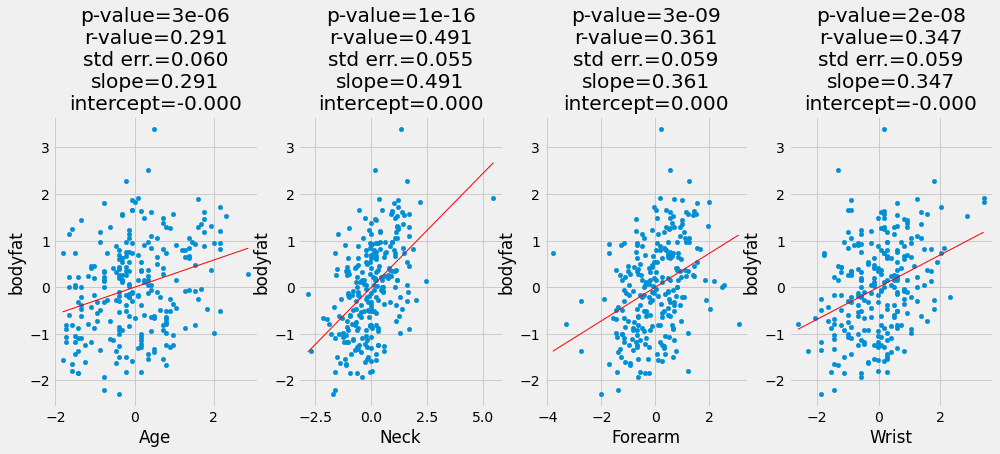

In [37]:
# now regress with scaled values.
regress_with_stats(df_penrose_scaled, observations)      

**What if we want to fit a multinomial regression? I.e., use all the observations as input/independent variables**

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[observations],
                                                               df_penrose['bodyfat'])









## oops; linregress assumes regression on one variable only.


ValueError: ignored

## Scikit-learn
Scikit-learn implements [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as well.

All regression/classification classes in scikit-learn assume two functions:

- `.fit(X, y)`: fit/train the model giving training data `X` (the feature matrix) and `y` (the true values)
- `.predict(X)`: given a feature matrix, return the predicted `y` values.

,truth,predicted
0,-0.820246,-0.762923
1,-1.562573,-0.408765
2,0.736245,-1.332367
3,-1.047733,-0.476792
4,1.143327,-1.173617


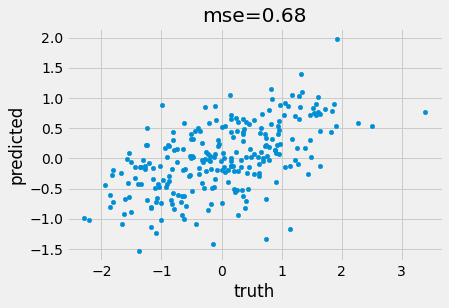

In [41]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
# fit the model
lr.fit(df_penrose_scaled[observations], df_penrose_scaled['bodyfat'])
# predict using the model
predictions = lr.predict(df_penrose_scaled[observations])
# compare predictions to truth
truth_and_pred = pd.DataFrame(zip(df_penrose_scaled['bodyfat'], predictions), columns=['truth', 'predicted'])
mse = ((truth_and_pred.truth-truth_and_pred.predicted)**2).sum()/len(truth_and_pred)
truth_and_pred.plot.scatter(x='truth', y='predicted', title='mse=%.2f' % mse)
truth_and_pred.head()

### Mean-squared error
$$MSE = \frac{1}{n} \sum_i (y_i - \hat{y}_i)^2$$

In [42]:
# what are the coefficients?
# print coefficients
print('coef=', lr.coef_)
print('intercept=', lr.intercept_)
pd.DataFrame(zip(observations, lr.coef_))

coef= [ 0.29460244  0.46715209  0.20201498 -0.18257659]
intercept= 8.325445303584595e-16


,0,1
0,Age,0.294602
1,Neck,0.467152
2,Forearm,0.202015
3,Wrist,-0.182577


### Why did the coefficients change so much?

## Let's actually make "predictions"

Up to now we've been fitting regression models on all the data and inspecting its goodness of fit. However, if we are using this as an actual predictive model, we'd want to assess how good the prediction is on **unseen** data.

In [58]:
df_train = df_penrose_scaled.sample(frac=0.5, random_state=42)
df_test = df_penrose_scaled.drop(df_train.index)
print('%d training and %d testing samples' % (len(df_train), len(df_test)))

126 training and 126 testing samples


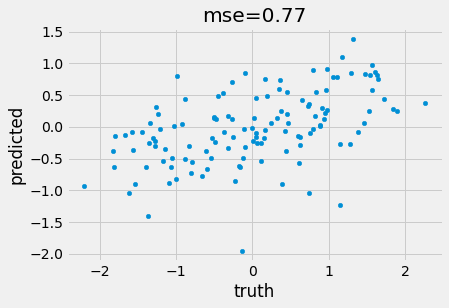

In [59]:
lr = LinearRegression()
lr.fit(df_train[observations], df_train['bodyfat'])
predictions = lr.predict(df_test[observations])
truth_and_pred = pd.DataFrame(zip(df_test['bodyfat'], predictions), columns=['truth', 'predicted'])
mse = ((truth_and_pred.truth-truth_and_pred.predicted)**2).sum()/len(truth_and_pred)
truth_and_pred.plot.scatter(x='truth', y='predicted', title='mse=%.2f' % mse)


### Why is MSE higher here?

We could also use the polyfit function

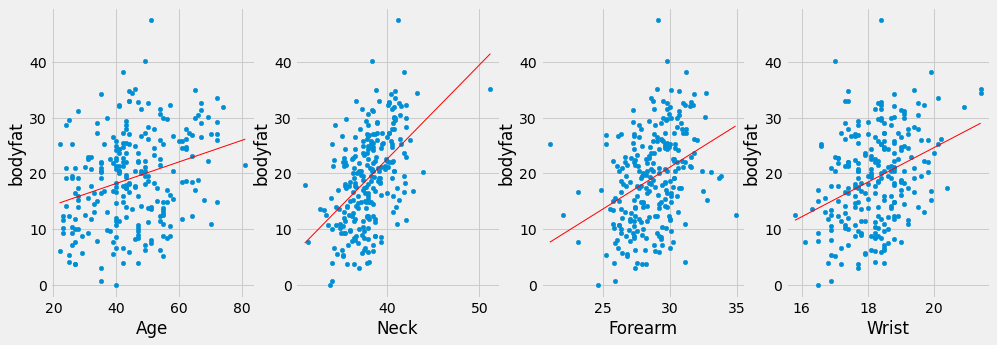

In [60]:
# Let's try to fit a linear model with PolyFit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    # Fit our curve
    x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 1)
    
    # Plot regular points
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    
    # Plot curve
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

## Non-Linear Models? 

So far we have only looked at the linear case -- what happens if we try to fit a polynomial to this data?

Why would we want to fit some higher order polynomial on this data? Why is it a good idea or a bad idea?

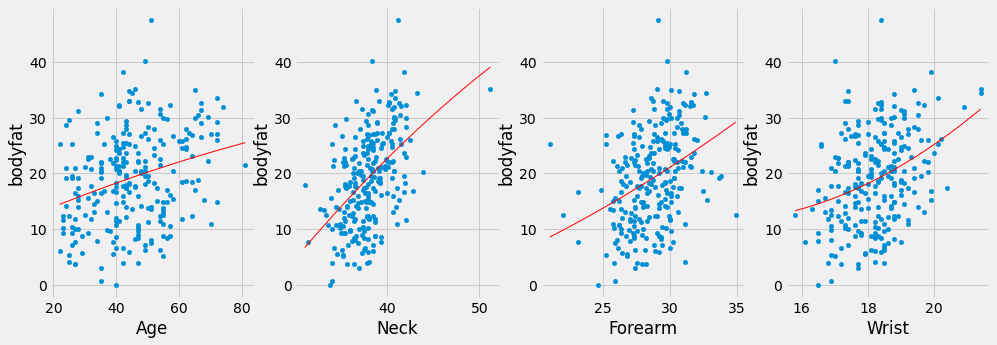

In [61]:
# Let's try fitting a degree 2 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    
    # Fit the polynomial.
    x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 2)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    
    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

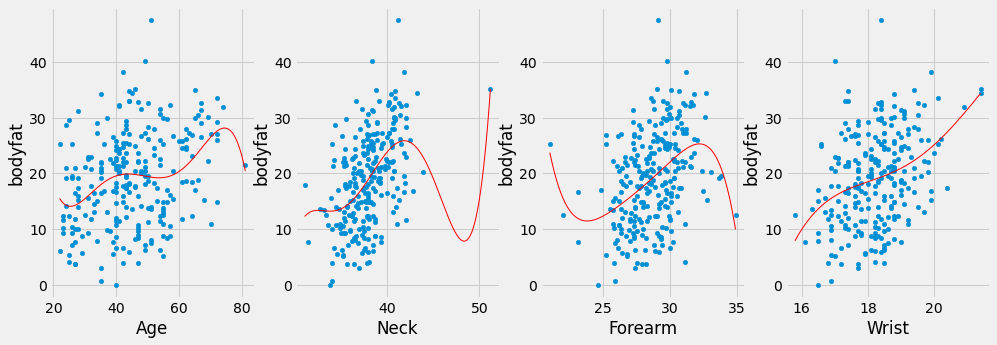

In [63]:
# Let's try fitting a degree 5 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    
    # Fit the polynomial.
    x5, x4, x3, x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 5)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    
    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x5 * pts**5 + x4 * pts**4 + x3 * pts**3 + x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

## Regressions and Plots with StatsModels and Seaborn

Statsmodels (you'll likely need to install it) gives a much more R-like interface to linear modeling.  You can read [more about it here](https://www.statsmodels.org/stable/index.html).

In [64]:
import statsmodels.api as sm
df_ind = df_penrose[['Neck', 'Wrist']]
df_target = df_penrose['bodyfat']

In [65]:
X = df_ind
y = df_target

# Note the difference in argument order
# Call: endog, then exog (dependent, indepenednt)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model
# Print out the statistics
model.summary()
#fig, ax = plt.subplots(figsize=(12,8))
#fig = sm.graphics.plot_partregress(endog="bodyfat", exog_i=['Abdomen', 'Neck'], exog_others='', data=df_penrose)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                bodyfat   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              823.5
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                   9.64e-111
Time:                        19:22:39   Log-Likelihood:                         -868.15
No. Observations:                 252   AIC:                                      1740.
Df Residuals:                     250   BIC:                                      1747.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Neck           1.6874      0.295      5.714      0.000       1.106       2.269
Wrist         -2.4602      0.616     -3.995      0.000      -3.673      -1.247
==============================================================================
Omnibus:                        2.850   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.309
Skew:                           0.107   Prob(JB):                        0.315
Kurtosis:                       2.583   Cond. No.                         60.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use the [single regressor plot](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.graphics.api.plot_partregress.html#statsmodels.graphics.api.plot_partregress).

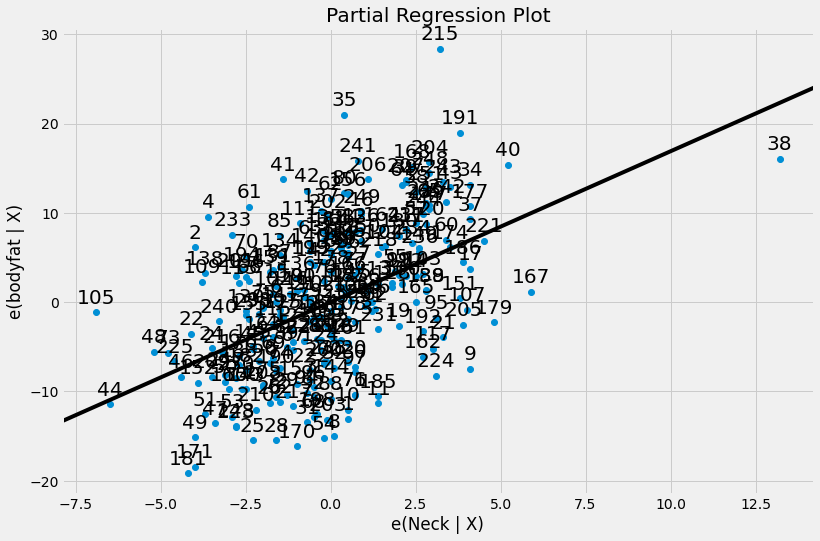

In [66]:
from statsmodels.graphics.regressionplots import plot_partregress
fig, ax = plt.subplots(figsize=(12,8))
plot_partregress(endog='bodyfat', exog_i='Neck', exog_others='', data=df_penrose, ax=ax)
plt.show()

If we have multiple elements in our regression then we need to use a different plot.

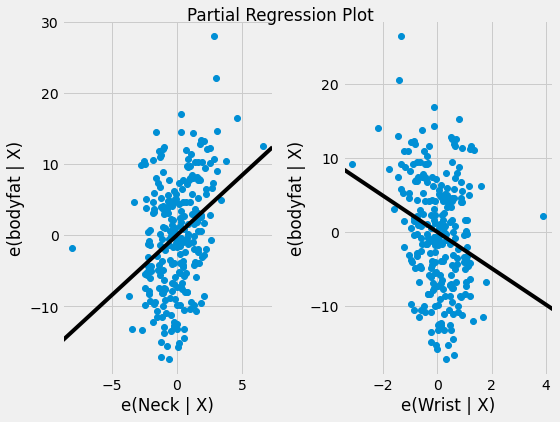

In [67]:
# Multiple regression plot
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(model, fig=fig)
plt.show()

Another way to work with regressions and their plots is using the [Seaborn Regression Package](https://seaborn.pydata.org/tutorial/regression.html)

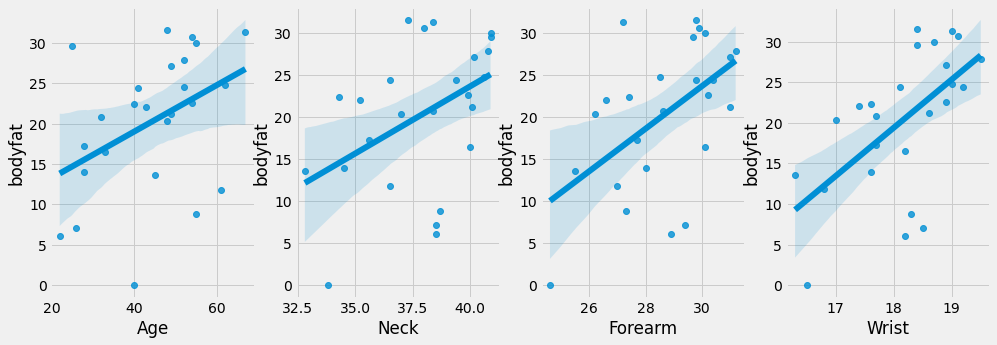

In [68]:
# Another way to do simple exploratory plots
import seaborn as sns
df_test = df_penrose.sample(frac=0.10, replace=False)
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    sns.regplot(x=o, y='bodyfat', data=df_test, ax=ax[i])
    #g.axes.set_xlim(df_test[o].min()*.95,df_test[o].max()*1.05)
    


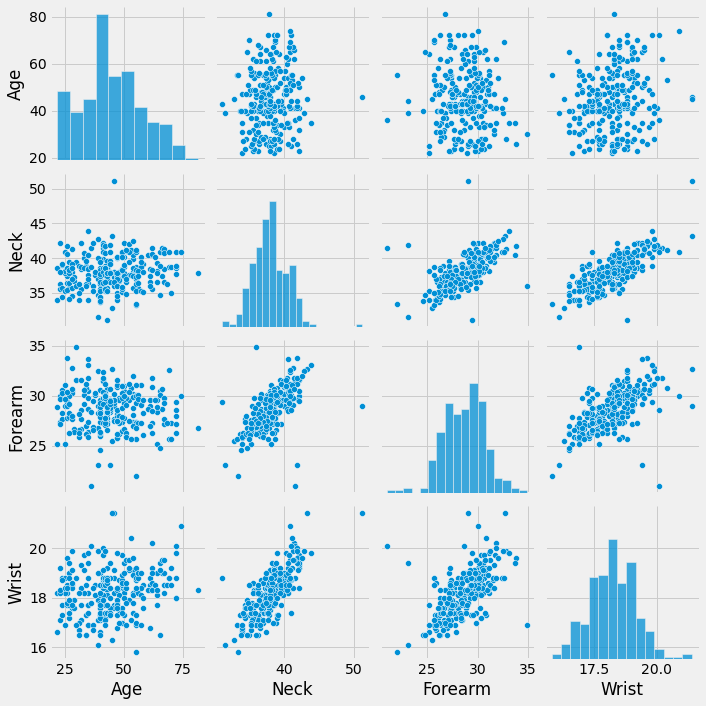

In [57]:
# As we saw before we can also use the sns pairplot.
sns.pairplot(df_penrose[observations])

## Linear Regressions and the Bias v. Variance Tradeoff

Another nice simulator to play with is [this one](https://ndirienzo.shinyapps.io/linear_regression_sim/) which is from [Prof. Nicholas DiRienzo](https://ischool.arizona.edu/people/nicholas-dirienzo) from ASU's School of Information 

## Logistic Regression

We can also use sklearn to do a quick logistic regression.  Remember that for logistic regression we are testing whether or not something is true, so we need to add a variable to our data.

Someone is obese if their body fat is >32% so we'll add a dummy for that!

In [48]:
df_penrose['obese'] = df_penrose.apply(lambda x: 1 if x['bodyfat'] > 32 else 0, axis=1)

In [49]:
df_penrose['obese'] = df_penrose.apply(lambda x: 1 if x['bodyfat'] > 32 else 0, axis=1)

In [50]:
# We're going to use sklearn to build us a classifier.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# setup our data for testing and training.

X_train, X_test, y_train, y_test = train_test_split(df_penrose[observations],
                                                    df_penrose['obese'],
                                                    test_size=0.2)


In [55]:
X_train.head()

,Age,Neck,Forearm,Wrist
97,50,38.7,27.8,18.2
135,44,37.8,28.8,17.6
140,40,37.4,27.9,16.6
85,67,36.5,27.7,18.2
73,55,33.2,25.7,16.9


In [53]:
# Fit that model!
logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced') 
model = logisticRegr.fit(X_train, y_train)

Accuracy Score is: 0.7843137254901961


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


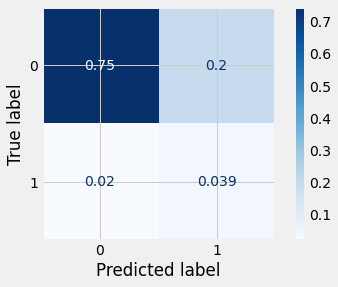

In [56]:
# Fit and plot!
from sklearn.metrics import accuracy_score, plot_confusion_matrix
y_pred = model.predict(X_test)
print(f"Accuracy Score is: {accuracy_score(y_test, y_pred)}")
plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=logisticRegr.classes_,
                                 cmap=plt.cm.Blues, normalize='all')